In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [ ]:
vgg = models.vgg19(weights='VGG19_Weights.DEFAULT').features

for param in vgg.parameters():
    param.requires_grad_(False)
vgg

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 49.3MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

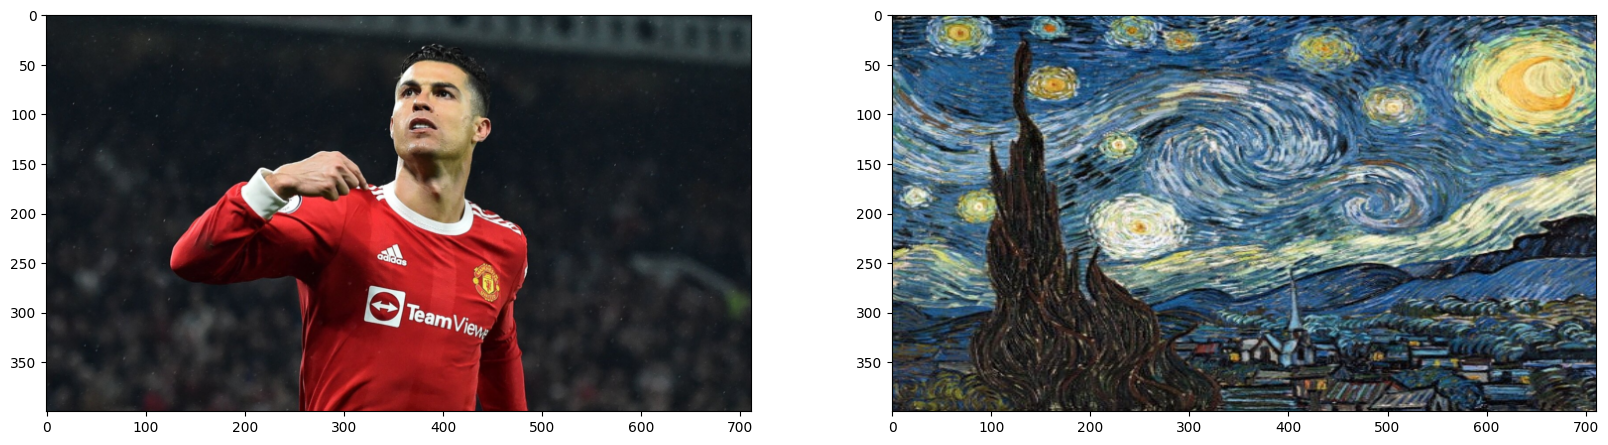

In [ ]:
def load_image(img_path, max_size=400, shape=None):

    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

content = load_image('/content/content.png')
style = load_image('/content/style1.png', shape=content.shape[-2:])

def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                 '5':  'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [ ]:
def gram_matrix(tensor):


    gram = None
    b, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True)

In [ ]:
style_weights = {'conv1_1': 1.,
'conv2_1': 0.8,
'conv3_1': 0.5,
'conv4_1': 0.3,
'conv5_1': 0.1}

content_weight = 1
style_weight = 1e6

In [ ]:
def adjust_weights():
    style_percentage = float(input("Enter the percentage of style (0-100): "))
    if style_percentage < 0 or style_percentage > 100:
        print("Invalid input. Please enter a value between 0 and 100.")
        return

    content_percentage = 100 - style_percentage
    style_weight = style_percentage / 100 * 1e6
    content_weight = content_percentage / 100

    return content_weight, style_weight

content_weight, style_weight = adjust_weights()

Enter the percentage of style (0-100): 10


Total loss:  9429133.0


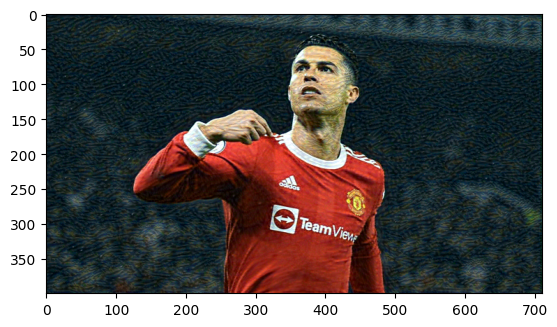

Total loss:  4577781.0


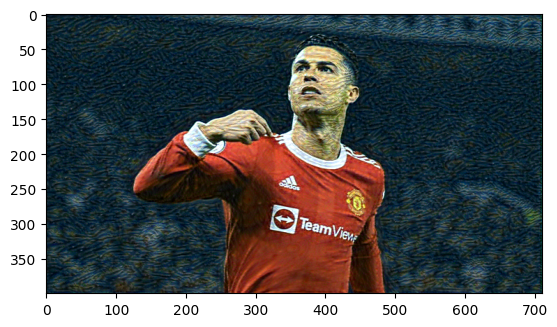

Total loss:  2866567.75


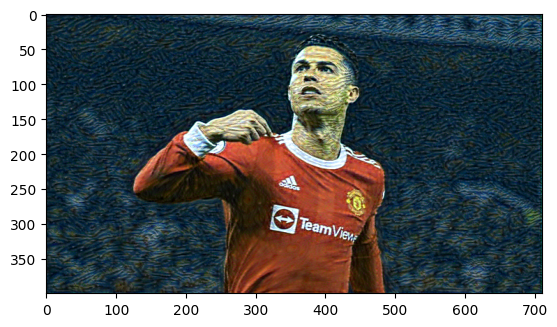

Total loss:  1964444.875


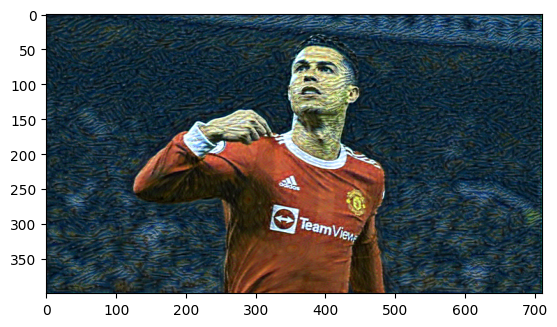

Total loss:  1386927.0


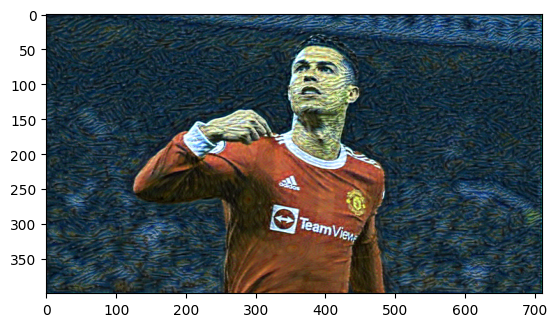

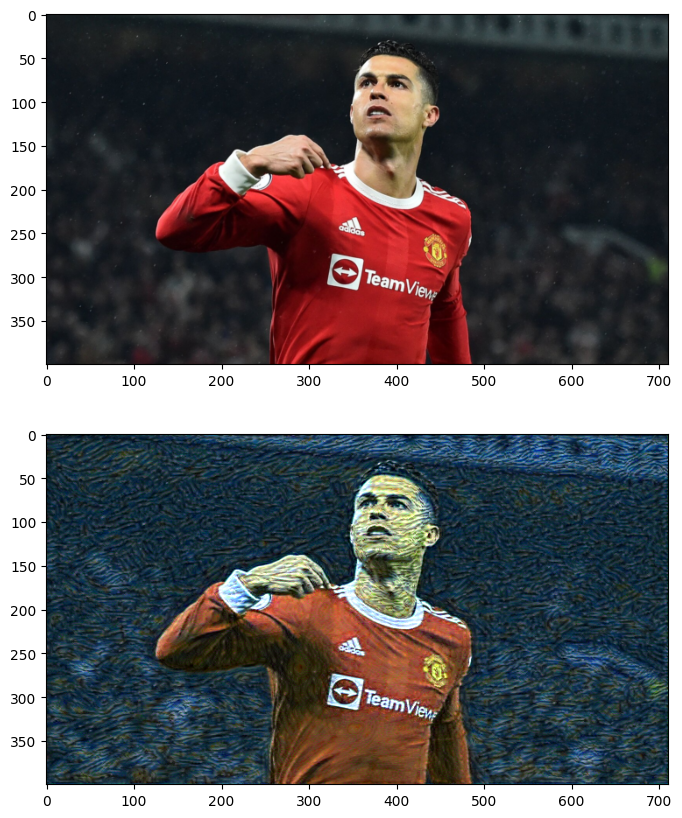

In [ ]:
show_every = 200

optimizer = optim.Adam([target], lr=0.003)
steps = 1000

for ii in range(1, steps+1):

    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))